# Training Wmap for few-shot text classification
This notebook is the second of two to accompany our [Few-Shot Text Classification](https://few-shot-text-classification.fastforwardlabs.com/) report in which we dive into the ins and outs of latent text embeddings for text classifications in several limited-labeled-data regimes. In this notebook we explore how to use latent text embeddings when there are *some* labeled training examples for each of the label names of interest. 

The technique is a continuation of our first notebook in which we demonstrated how to perform text classification with *no* labeled training data by relying on the semantic meaning of the labels themselves. In this method, label names and the text document you wish to classify are embedded with Sentence-BERT (SBERT). Classification proceeds by assiging the label name whose embedding maximizes the cosine similarity to the text document embedding. 

In our first notebook ([Optimizing Zmap for "on-the-fly" text classification](https://github.com/fastforwardlabs/few-shot-text-classification/blob/88854041ccea4f94bc4d25aefe479576854d5e24/notebooks/Zmap_Experiments.ipynb)) we improved on this method by optimizing a mapping (Zmap) between SBERT space and word2vec (w2v) space since SBERT is primed to produce better *sentence* embeddings, while w2v produces better *word* embeddings. 

In this notebook, we'll build on this technique and demonstrate how to learn an additional mapping (Wmap) using **labeled** training data.  

### Notes
* This notebook makes use of large Transformer models so **GPUs are strongly prefered**. 
* You can access free GPUs by running this notebook with Google Colaboratory, a Jupyter Notebook environment that runs in the browser using Google Cloud. [This introductory Colab](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=K-NVg7RjyeTk) demonstrates how to use Colab with GitHub. 

---

While most cells in this notebook can be executed, **it is not intended to be run from start to finish because it requires data resources that we do not currently include in the repo.** Specifically, the cells focused on the AG News dataset can be executed all the way through, however, cells processing Reddit data will be missing key data resources. 

This notebook is intended as an additional resource that walks through the analysis we performed for our [Few-Shot Text Classification](https://few-shot-text-classification.fastforwardlabs.com/) report. 

---

## Installation in a Colab environment
If you followed the installation instructions in the README and are running this notebook locally or in your CML/CDSW environment, you can skip this section. 

However, if you've opened this as a Colab notebook to take advantage of the free GPUs, follow the steps below. 

1. Open this notebook with Google's Colaboratory. 
2. In the top menu select Runtime --> Change runtime type
3. A pop-up menu will appear.  Under Hardware accelerator, select GPU

Now follow the installation and data download steps below. 

In [1]:
# clone our few-shot repo
!git clone https://github.com/fastforwardlabs/few-shot-text-classification.git

Cloning into 'few-shot-text-classification'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (238/238), done.
remote: Total 942 (delta 224), reused 267 (delta 136), pack-reused 567
Receiving objects: 100% (942/942), 124.00 MiB | 36.90 MiB/s, done.
Resolving deltas: 100% (571/571), done.


In [ ]:
!mv few-shot-text-classification/fewshot . 
!mv few-shot-text-classification/setup.py .

In [ ]:
!pip3 install datasets==1.1.2
!pip3 install transformers==3.3.0
!pip3 install -e .

Running this as a Colab notebook does not allow you to access any of the resources provided in the repo (which is why we had to clone the repo above), so the following cell will download some key data resources. 

In [ ]:
# Upload data files
!wget https://raw.githubusercontent.com/fastforwardlabs/few-shot-text-classification/c0f4e7b49ee13af95da96d0e04c8eb6311caad77/data/reddit/reddit_dataset.pkl -P data/reddit
!wget https://raw.githubusercontent.com/fastforwardlabs/few-shot-text-classification/c0f4e7b49ee13af95da96d0e04c8eb6311caad77/data/agnews/agnews_dataset.pkl -P data/agnews
!wget https://raw.githubusercontent.com/fastforwardlabs/few-shot-text-classification/c0f4e7b49ee13af95da96d0e04c8eb6311caad77/data/maps/Zmap_20k_w2v_words_alpha0.pt -P data/maps

# Getting started

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

from fewshot.data.loaders import (
    load_or_cache_data, 
    _load_agnews_dataset,
    _create_dataset_from_df
)

from fewshot.data.utils import select_subsample, expand_labels

from fewshot.embeddings.sentence_embeddings import (
    load_transformer_model_and_tokenizer,
    get_sentence_embeddings,
)

from fewshot.models.few_shot import (
    FewShotLinearRegression, 
    BayesianMSELoss,
    prepare_dataloader,
    train,
)   

from fewshot.eval import predict_and_score

from fewshot.utils import (
    fewshot_filename,
    torch_load,
    torch_save,
    pickle_load,
    pickle_save,
    to_tensor,
    to_list,
)


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

## Load SentenceBERT 

Running the cell below for the first time will initialize a download of pretrained model weights from the [HuggingFace Model Repository](https://huggingface.co/models). 

In [ ]:
## Load SBERT embedding model
model, tokenizer = load_transformer_model_and_tokenizer("deepset/sentence_bert")

## Load Training & Validation Data
  In the following experiments we use two datasets: AG News and the Reddit dataset, both of which can be found on the [HuggingFace Dataset Repository](https://huggingface.co/datasets) (CAUTION: the Reddit dataset is *very* large and takes a looooong time to download. In our experiments we have already downsampled the dataset to fit in memory. Details on how we did that can be found in [this notebook](https://github.com/fastforwardlabs/few-shot-text-classification/blob/88854041ccea4f94bc4d25aefe479576854d5e24/notebooks/CreatingRedditDataset.ipynb).)

The AG News train set contains 120,000 examples, of which we'll randomly sample up to 1000 for training (in a later block) and exactly 1000 as a validation set. 


In [ ]:
# load agnews train set -- this returns the full 120k examples as a pandas dataframe
df_news = _load_agnews_dataset(split="train")

In [ ]:
# Generate a subset containing 2000 examples for each category
df_news_subset = select_subsample(df_news, sample_size=2000, random_state=42)

# Split the sample in half -- 1000 for training, 1000 for validation
df_news_train, df_news_valid, _, _ = train_test_split(df_news_subset, 
                                                      df_news_subset['category'], 
                                                      test_size=.5, 
                                                      random_state=42, 
                                                      stratify=df_news_subset['category'])

In [ ]:
# Compute SBERT embeddings for each example in the validation set
news_valid = _create_dataset_from_df(df_news_valid, 'text')

Computing sentence representations: 100%|██████████| 251/251 [00:53<00:00,  4.72it/s]


In [ ]:
pickle_save(news_valid_data, "../my_data/agnews/agnews_subset_train1000.pkl")

The Reddit dataset contains nearly 4M examples and is around 20 GiB. In a separate notebook we have already downsampled this dataset to include only 16 of the most popular subreddits and, from those, randomly selected 1000 for training and 1000 for validation. We uploaded these subsets to this notebook. 

**Note: these resources are not currently included in the repo so this cell will not execute.**

In [ ]:
df_reddit_train = pd.read_csv("data/reddit/reddit_subset_train1000.csv")
df_reddit_valid = pd.read_csv("data/reddit/reddit_subset_valid1000.csv")

## Load Test Data

These are the same sets that were used in the first notebook of this series which demonstrated how to classify text documents without any training data. Here, they will serve as evaluation sets. At the end of this notebook we compare classification performance between having *no* training data and having *some*.  

In [ ]:
reddit_test = load_or_cache_data("data/reddit", "reddit")

Checking for cached data...


In [ ]:
news_test = load_or_cache_data("data/agnews", "agnews")

Checking for cached data...


## Load a Zmap 
In this notebook we'll use training data to learn a new transformation, Wmap, which is learned from SBERT*Zmap representations. The Zmap in the cell below was optimized in our [first notebook](https://github.com/fastforwardlabs/few-shot-text-classification/blob/88854041ccea4f94bc4d25aefe479576854d5e24/notebooks/Zmap_Experiments.ipynb) and we reuse it here. 

In [ ]:
# Load a relevant Zmap for this dataset 
# Note: this one is the most general and will work for all datasets
Zmap_w2v = torch_load(fewshot_filename("data/maps", "Zmap_20k_w2v_words_alpha0.pt"))

# Hyperparameter search 

A hyperparameter search is an essential part of any machine learning workflow. This often requires additional labeled data, specifically, a reasonably-sized validation set. In a real few-shot situation, we may not have enough data to split off a validation set from our training set.  In that case, a cross validation scheme would be more appropriate. 

Fortunately, the AG News and Reddit datasets have plenty of labeled data, which allows us to create validation and training sets in order to perform this crucial step. This also allows us to provide guidance on rule-of-thumb values that we found work well, hopefully saving you time when applying this technique to your data. We caution that while we found values that seem to translate well across datasets, they are not guaranteed to optimize the performance for your particular use case.  

Executing the cells below will re-run our simple hyperparameter tuning process. The `FewShotLinearRegression` model has two hyperparameters: the `learning rate` and the value of the regularization, `lambda`. 

In [ ]:
def hptuning(data_loader, Zmap, validation_data, learning_rates, lambdas, epochs, device='cpu'):
    """Simple hyperparameter tuning strategy for Wmap"""
    score = 0
    for lr in learning_rates:
        for lam in lambdas:
            # instantiate a model and loss function
            fewshot_model = FewShotLinearRegression(Zmap.size()[1], Zmap.size()[1], 
                                                    loss_fcn=BayesianMSELoss(device=device), 
                                                    lr=lr, 
                                                    device=device)
            # train
            loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)
            # extract model weights
            Wmap = fewshot_model.linear.weight.detach().cpu()
            # predict and score on the validation set
            new_score = predict_and_score(validation_data, linear_maps=[Zmap, Wmap])

            if new_score > score:
                score = new_score
                best_lr = lr
                best_lam = lam
                best_model = fewshot_model
                loss = loss_history
                print(f"Best hps so far: ({best_lr}, {best_lam}) with a score of {score}")

    return best_model, best_lr, best_lam, loss

We ran the cell below several times using training sets ranging from a few hundred to a few thousand examples for each of the AG News and Reddit datasets.  In most cases, we found a `learning_rate=0.01` and `lambda=100` optimized the model on the validation set. However, we get just about the same performance with `learning_rate=0.1` and `lambda=500` (about a one point difference). Smaller learning rates require more epochs to fully minimize the loss function which translates to slower model training. For this reason, we opt to use the latter set of parameters with fewer epochs for the remainder of the notebook. 

**Note: running this cell takes about a half hour with a GPU and much longer without.**

In [ ]:
# choose a training set
train_set = "agnews" # "reddit"

if train_set == "agnews":
    df_train_set = df_news_train 
    validation_set = news_valid
else:
    df_train_set = df_reddit_train
    validiation_set = reddit_valid

# choose number of examples per category 
# for AG News, total training set = 4*samples_per_category
# for Reddit, total training set = 10*samples_per_cateogry
samples_per_category = 200

# randomly sample a subset of training examples
df_train_subset = select_subsample(df_train_set, sample_size=samples_per_category)
# convert the pandas dataframe into a dataset
train_subset = _create_dataset_from_df(df_train_subset, 'text')
# compute sbert embeddings for each example text
#train_subset.calc_sbert_embeddings()
# ensure each example has a sbert embedding for its category name
train_subset = expand_labels(train_subset)
# convert the dataset into a PyTorch Dataloader object
data_loader = prepare_dataloader(train_subset, Zmap_w2v)

# learning rates to tune over
lrs = [0.01, .1, .5]
# lambda regularization values to tune over
lambdas = [50, 100, 500, 750, 1000]
epochs = 1000

# hyperparameter tuning
best_model, best_lr, best_lam, loss = hptuning(data_loader, 
                                               Zmap_w2v,
                                               validation_set, 
                                               lrs, 
                                               lambdas, 
                                               epochs,
                                               device='cuda')

print(best_lr, best_lam)

Computing sentence representations: 100%|██████████| 51/51 [00:10<00:00,  4.79it/s]


Best hps so far: (0.01, 50) with a score of 75.225
Best hps so far: (0.01, 100) with a score of 77.825
0.01 100


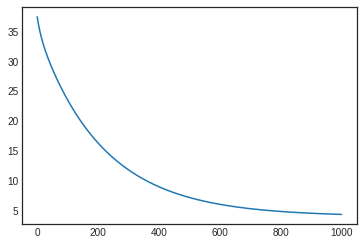

In [ ]:
plt.plot(loss)

# Training Wmap on the AG News dataset

In this experiment we'll train Wmap using some number of labeled examples for each category. 

Wmap is learned through a modification of the traditional loss function for linear least-squares regression with l2 regularization. See the details in our accompanying [report](https://few-shot-text-classification.fastforwardlabs.com/).

### Training set of 400 examples (100 examples per category)

To begin, we'll start with just 100 annotated examples for each of the four categories in the AG News dataset, for a total of 400 labeled examples. 

In [ ]:
# select a subsample of the AG news train set containing, at most, 400 examples 
df_news_train100 = select_subsample(df_news_train, sample_size=100)

# convert that DataFrame to a Dataset
news_train100 = _create_dataset_from_df(df_news_train100, 'text')
# compute sbert embeddings for each example
#news_train100.calc_sbert_embeddings()

# this is required due the particular implementation details of our Dataset class
news_train100 = expand_labels(news_train100)

/content/fewshot/data/utils.py:81: UserWarning: Should run dataset.calc_sbert_embeddings() first.  In the future this will fail.
  "Should run dataset.calc_sbert_embeddings() first.  In the future this will fail."
Computing sentence representations: 100%|██████████| 26/26 [00:05<00:00,  4.85it/s]


In [ ]:
# convert the properly formatted training Dataset into a PyTorch DataLoader
data_loader = prepare_dataloader(news_train100, Zmap_w2v)

### Define training and model parameters

In [ ]:
# dimensions for Wmap should match the last dimension of Zmap since Wmap will modify SBERT*Zmap
model_size = (Zmap_w2v.size()[1], Zmap_w2v.size()[1])     
lr = 0.1          # learning rate
lam = 500         # lambda regularization value
epochs = 100      # training epochs
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# instantiate a model and loss function
fewshot_model = FewShotLinearRegression(*model_size, 
                                        loss_fcn=BayesianMSELoss(device=device), 
                                        lr=lr, 
                                        device=device)
# train
loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)

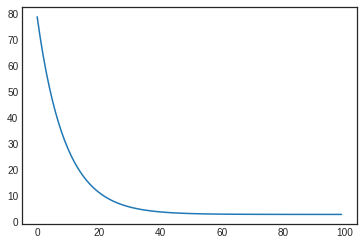

In [ ]:
# visualize the loss as a function of epochs
plt.plot(loss_history);

Once we have finished the training process, extracting Wmap is as simple as pulling the weights from the linear model as shown below. Wmap is thus a matrix that can be used to transform the SBERT*Zmap representations while taking into account labeled training data. 

In [ ]:
# grab Wmap (weight matrix of the model)
Wmap_100 = fewshot_model.linear.weight.detach().cpu()

# predict on test set
test_score = predict_and_score(news_test, linear_maps=[Zmap_w2v, Wmap_100])

# predict on train set
train_score = predict_and_score(news_train100, linear_maps=[Zmap_w2v, Wmap_100])

print(test_score, train_score)

76.97368421052632 79.25


### Training set of 2000 examples (500 per category)

In [ ]:
df_news_train500 = select_subsample(df_news_train, sample_size=500)

news_train500 = _create_dataset_from_df(df_news_train500, 'text')
#news_train500.calc_sbert_embeddings()

news_train500 = expand_labels(news_train500)

data_loader = prepare_dataloader(news_train500, Zmap_w2v)

/content/fewshot/data/utils.py:81: UserWarning: Should run dataset.calc_sbert_embeddings() first.  In the future this will fail.
  "Should run dataset.calc_sbert_embeddings() first.  In the future this will fail."
Computing sentence representations: 100%|██████████| 126/126 [00:26<00:00,  4.76it/s]


In [ ]:
# instantiate a model and loss function
fewshot_model = FewShotLinearRegression(*model_size, 
                                        loss_fcn=BayesianMSELoss(device=device), 
                                        lr=lr, 
                                        device=device)
# train
loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)

We've now trained two Wmaps -- one trained with only 400 examples and this one trained on 2000 examples. 

In [ ]:
# grab the new Wmap
Wmap_500 = fewshot_model.linear.weight.detach().cpu()

# predict on test set
test_score = predict_and_score(news_test, linear_maps=[Zmap_w2v, Wmap_500])

# predict on train set
train_score = predict_and_score(news_train500, linear_maps=[Zmap_w2v, Wmap_500])

print(test_score, train_score)

77.67105263157895 77.8


Training on 5 times more data only increased our classification accuracy by about a point, indicating that we're likely hitting the limits of model performance for this technique. 

Below we save the Wmap we trained for use in the demo that accompanies this repo.

In [ ]:
# Save this Wmap for the demo
torch_save(Wmap_500, "Wmap_agnews_lr0.1_lam500_500expercat.pt")

/content/fewshot/utils.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.save(torch.tensor(vector, dtype=torch.float), filename)


### Learning Curve
We saw that significantly increasing the number of training examples didn't result in substantial performance gains. 

In this section we look at train and test accuracy as a function of how many training examples we use. Known as a **learning curve**, this diagnostic can help you determine an optimal sample size for the complexity of your model and whether you might be overfitting.  

In addition to choosing various `sample_sizes`, we also consider diferent `random_states` in order to account for random sample selection. That is, what affect would you see if you had had a different training sample? You may collect 500 labeled examples but what if you had collected 500 *different* ones? Understanding this source of variance allows us to probe the robustness of a model by computing error bars. 

Specifically, we train on five different randomly selected subsamples of 5 training examples each (per category -- 20 total training examples), then we repeat this procedure for each of the `sample_sizes`. 

We'll use the results of this experiment in a figure we construct at the end of the notebook. 

**NOTE: running this cell will take 30-60 minutes even with a GPU.**

In [128]:
def calc_learning_curve(train_df, test_data, text_column, lr, lam, epochs, device):
    random_states = [42, 36, 90, 87, 12]
    results = {}
    for random_state in random_states:
        test_scores = []
        train_scores = []
        sample_sizes = [5, 10, 25, 50, 75, 100, 250, 500]
        for sample_size in sample_sizes:
            sample_df = select_subsample(train_df, sample_size=sample_size, 
                                          random_state=random_state)
            train_subset = _create_dataset_from_df(sample_df, text_column)
            train_subset = expand_labels(train_subset)
            data_loader = prepare_dataloader(train_subset, Zmap_w2v)
            fewshot_model = FewShotLinearRegression(Zmap_w2v.size()[1], Zmap_w2v.size()[1],
                                                    loss_fcn=BayesianMSELoss(device=device), 
                                                    lr=lr, 
                                                    device=device)
            loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)
            Wmap = fewshot_model.linear.weight.detach().cpu()
            # predict on test set
            test_score = predict_and_score(test_data, linear_maps=[Zmap_w2v, Wmap])
            test_scores.append(test_score)
            # predict on train set
            train_score = predict_and_score(train_subset, linear_maps=[Zmap_w2v, Wmap])
            train_scores.append(train_score)

            results[str(random_state)] = [test_scores, train_scores]

    pickle_save(results, "learning_curve_results.pkl")
    return results

In [ ]:
news_results = calc_learning_curve(df_news_train, news_test, text_column='text', 
                                   lr=0.1, lam=500, epochs=100, device='cuda')

# Training Wmap on the Reddit dataset
We perform the same basic experiments for the Reddit dataset. 

In [ ]:
# select a subset of the reddit training set -- 100 examples per category (1000 total)
df_reddit_train100 = select_subsample(df_reddit_train, sample_size=100)
# convert that to a properly formated Dataset object
reddit_train100 = _create_dataset_from_df(df_reddit_train100, 'summary')
reddit_train100 = expand_labels(reddit_train100)

data_loader = prepare_dataloader(reddit_train100, Zmap_w2v)

Computing sentence representations: 100%|██████████| 64/64 [00:13<00:00,  4.78it/s]


In [ ]:
# instantiate a model and loss function
fewshot_model = FewShotLinearRegression(*model_size, 
                                        loss_fcn=BayesianMSELoss(device=device), 
                                        lr=lr, 
                                        device=device)
# train
loss_history = train(fewshot_model, data_loader, num_epochs=epochs, lam=lam)

In [ ]:
# grab the Wmap now trained on reddit set
Wmap_100 = fewshot_model.linear.weight.detach().cpu()
# predict on test set
test_score = predict_and_score(reddit_test, linear_maps=[Zmap_w2v, Wmap_100])
# predict on train set
train_score = predict_and_score(reddit_test, linear_maps=[Zmap_w2v, Wmap_100])

print(test_score, train_score)

### Learning curve

Note that running this cell will take 30-60 minutes even with a GPU due to the number of experiments run. 

In [ ]:
reddit_results = calc_learning_curve(df_reddit_train, reddit_test, text_column='summary', 
                                     lr=0.1, lam=500, epochs=100, device='cuda')

### Aggregating results

Both of our learning curve experiments were performed over several random samplings of data. Here we combine the results and obtain the average and standard deviation of all the trials for both datasets

In [12]:
def aggregate_results(results):
    agg_results = {}

    test_scores = np.array([np.array(scores[0]) for _, scores in results.items()])
    train_scores = np.array([np.array(scores[1]) for _, scores in results.items()])

    agg_results['test_avg'] = np.mean(test_scores, axis=0)
    agg_results['test_pos_err'] = agg_results['test_avg'] + np.std(test_scores, axis=0)
    agg_results['test_neg_err'] = agg_results['test_avg'] - np.std(test_scores, axis=0)

    agg_results['train_avg'] = np.mean(train_scores, axis=0)
    agg_results['train_pos_err'] = agg_results['train_avg'] + np.std(train_scores, axis=0)
    agg_results['train_neg_err'] = agg_results['train_avg'] - np.std(train_scores, axis=0)
    return agg_results

results = pickle_load("agnews_learning_curve_results.pkl")

agg_results  = aggregate_results(results)

## Make a pretty figure

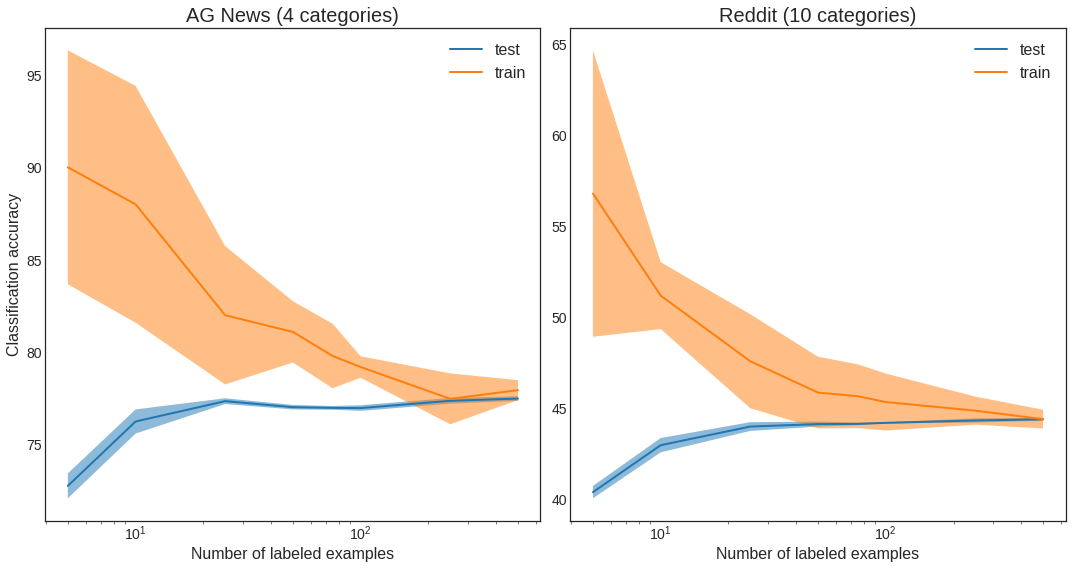

In [15]:
plt.style.use("seaborn-white")

sample_sizes = [5, 10, 25, 50, 75, 100, 250, 500]

news_results = pickle_load("agnews_learning_curve_results.pkl")
agg_results_news = aggregate_results(news_results)

reddit_results = pickle_load("reddit_learning_curve_results.pkl")
agg_results_reddit = aggregate_results(reddit_results)

def plot_learning_curve(ax, agg_results):
    ax.plot(sample_sizes, agg_results['test_avg'], lw=2, label="test")
    ax.fill_between(sample_sizes, 
                    agg_results['test_neg_err'], 
                    agg_results['test_pos_err'], 
                    alpha=0.5)
    ax.semilogx(sample_sizes, agg_results['train_avg'], lw=2, label="train")
    ax.fill_between(sample_sizes, 
                    agg_results['train_neg_err'], 
                    agg_results['train_pos_err'], 
                    alpha=0.5)
    
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
plot_learning_curve(ax, agg_results_news)
ax.set_title("AG News (4 categories)", fontsize=20)

ax.set_ylabel("Classification accuracy", fontsize=16)
ax.set_xlabel("Number of labeled examples", fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.tick_params(which='minor', length=3)
ax.legend(frameon=False, fontsize=16)

ax2 = fig.add_subplot(222)
plot_learning_curve(ax2, agg_results_reddit)
ax2.set_title("Reddit (10 categories)", fontsize=20)
ax2.set_xlabel("Number of labeled examples", fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.tick_params(which='minor', length=3)
ax2.legend(frameon=False, fontsize=16);
plt.tight_layout()
plt.savefig("learningcurves_agnews_reddit.png", transparent=True, dpi=150)

As we discuss in depth in the [report](https://few-shot-text-classification.fastforwardlabs.com/), the latent embedding technique is not only well suited to regimes in which only a limited amount of labeled data exists, it can *only handle* small amounts of data! Ultimately, our Wmap is a model with a relatively few number of parameters which mean that it can't capture the complexity of larger datasets resulting in performance that levels off after a few hundred training examples. 

# Text classification in limited-labeled-data regimes

Below we compare the performance of the three main ways that we use the latent embedding approach for text classification. 

To recap: 
1. First, we used SBERT representations of both the example text and each of the possible labels to perform text classification on-the-fly (no training data!)
2. Second, we optimized Zmap which projected SBERT embeddings into word2vec space in order to better capture the semantics of individual *words*. This improved performance on the AG News dataset but not the Reddit dataset because subreddit names were often too semantically vague or all-emcompassing.
3. Third, we used training data to learn an addition mapping, Wmap, between example text and their associated labels and this improved performance for both datasets. 

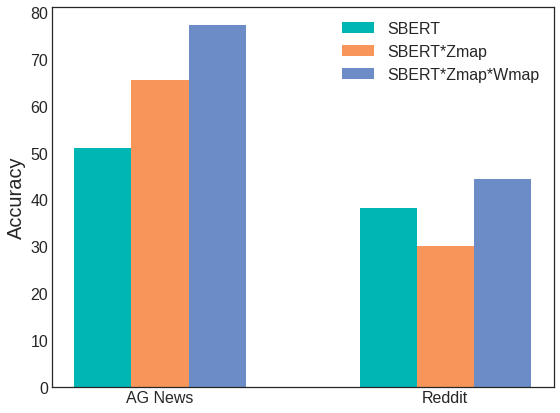

In [ ]:
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7']

# from the Zmap_Experiments Colab notebook
baseline_news_acc = 51.0921052631579
baseline_reddit_acc = 38.36712428402582

Zmap_news_acc = 65.57894736842104
Zmap_reddit_acc = 30.26335727490378

Wmap_news_acc = 77.42105263157895
Wmap_reddit_acc = 44.40769230769231

fig = plt.figure(figsize=(9,7))
width = 0.20
plt.bar(np.array([0, 1])-width, [baseline_news_acc, baseline_reddit_acc], 
        width=width, color=cldr_colors[0],  label='SBERT')
plt.bar(np.array([0, 1]), [Zmap_news_acc, Zmap_reddit_acc], 
        width=width, color=cldr_colors[1], label="SBERT*Zmap")
plt.bar(np.array([0, 1])+width, [Wmap_news_acc, Wmap_reddit_acc], 
        width=width, color=cldr_colors[2], label="SBERT*Zmap*Wmap")

plt.xticks([0,1], ['AG News', 'Reddit'], fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Accuracy", fontsize=20);
plt.legend(frameon=False, fontsize=16);

plt.savefig("accuracy_Wmap_agnews_reddit.png", transparent=True, dpi=150)

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***